# Express sklearn pipeline as codeflare pipeline
Reference: https://scikit-learn.org/stable/auto_examples/kernel_approximation/plot_scalable_poly_kernels.html#sphx-glr-auto-examples-kernel-approximation-plot-scalable-poly-kernels-py

In [1]:
%matplotlib inline


# Scalable learning with polynomial kernel aproximation

This example illustrates the use of :class:`PolynomialCountSketch` to
efficiently generate polynomial kernel feature-space approximations.
This is used to train linear classifiers that approximate the accuracy
of kernelized ones.

.. currentmodule:: sklearn.kernel_approximation

We use the Covtype dataset [2], trying to reproduce the experiments on the
original paper of Tensor Sketch [1], i.e. the algorithm implemented by
:class:`PolynomialCountSketch`.

First, we compute the accuracy of a linear classifier on the original
features. Then, we train linear classifiers on different numbers of
features (`n_components`) generated by :class:`PolynomialCountSketch`,
approximating the accuracy of a kernelized classifier in a scalable manner.


In [2]:
print(__doc__)

# Author: Daniel Lopez-Sanchez <lope@usal.es>
# License: BSD 3 clause
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_covtype
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, Normalizer
from sklearn.svm import LinearSVC
from sklearn.kernel_approximation import PolynomialCountSketch
from sklearn.pipeline import Pipeline, make_pipeline
import time

Automatically created module for IPython interactive environment


Load the Covtype dataset, which contains 581,012 samples
with 54 features each, distributed among 6 classes. The goal of this dataset
is to predict forest cover type from cartographic variables only
(no remotely sensed data). After loading, we transform it into a binary
classification problem to match the version of the dataset in the
LIBSVM webpage [2], which was the one used in [1].



In [3]:
X, y = fetch_covtype(return_X_y=True)

y[y != 2] = 0
y[y == 2] = 1  # We will try to separate class 2 from the other 6 classes.

Here we select 5,000 samples for training and 10,000 for testing.
To actually reproduce the results in the original Tensor Sketch paper,
select 100,000 for training.



In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=5_000,
                                                    test_size=10_000,
                                                    random_state=42)

Now scale features to the range [0, 1] to match the format of the dataset in
the LIBSVM webpage, and then normalize to unit length as done in the
original Tensor Sketch paper [1].



In [5]:
mm = make_pipeline(MinMaxScaler(), Normalizer())
X_train = mm.fit_transform(X_train)
X_test = mm.transform(X_test)

As a baseline, train a linear SVM on the original features and print the
accuracy. We also measure and store accuracies and training times to
plot them latter.



In [6]:
results = {}

lsvm = LinearSVC()
start = time.time()
lsvm.fit(X_train, y_train)
lsvm_time = time.time() - start
lsvm_score = 100 * lsvm.score(X_test, y_test)

results["LSVM"] = {"time": lsvm_time, "score": lsvm_score}
print(f"Linear SVM score on raw features: {lsvm_score:.2f}%")

Linear SVM score on raw features: 75.62%


Then we train linear SVMs on the features generated by
:class:`PolynomialCountSketch` with different values for `n_components`,
showing that these kernel feature approximations improve the accuracy
of linear classification. In typical application scenarios, `n_components`
should be larger than the number of features in the input representation
in order to achieve an improvement with respect to linear classification.
As a rule of thumb, the optimum of evaluation score / run time cost is
typically achieved at around `n_components` = 10 * `n_features`, though this
might depend on the specific dataset being handled. Note that, since the
original samples have 54 features, the explicit feature map of the
polynomial kernel of degree four would have approximately 8.5 million
features (precisely, 54^4). Thanks to :class:`PolynomialCountSketch`, we can
condense most of the discriminative information of that feature space into a
much more compact representation. We repeat the experiment 5 times to
compensate for the stochastic nature of :class:`PolynomialCountSketch`.



In [7]:
n_runs = 3
for n_components in [250, 500, 1000, 2000]:

    ps_lsvm_time = 0
    ps_lsvm_score = 0
    for _ in range(n_runs):

        pipeline = Pipeline(steps=[("kernel_approximator",
                                    PolynomialCountSketch(
                                        n_components=n_components,
                                        degree=4)),
                                   ("linear_classifier", LinearSVC())])

        start = time.time()
        pipeline.fit(X_train, y_train)
        ps_lsvm_time += time.time() - start
        ps_lsvm_score += 100 * pipeline.score(X_test, y_test)

    ps_lsvm_time /= n_runs
    ps_lsvm_score /= n_runs

    results[f"LSVM + PS({n_components})"] = {
        "time": ps_lsvm_time, "score": ps_lsvm_score
    }
    print(f"Linear SVM score on {n_components} PolynomialCountSketch " +
          f"features: {ps_lsvm_score:.2f}%")

Linear SVM score on 250 PolynomialCountSketch features: 76.11%
Linear SVM score on 500 PolynomialCountSketch features: 77.44%
Linear SVM score on 1000 PolynomialCountSketch features: 77.87%
Linear SVM score on 2000 PolynomialCountSketch features: 78.03%


Train a kernelized SVM to see how well :class:`PolynomialCountSketch`
is approximating the performance of the kernel. This, of course, may take
some time, as the SVC class has a relatively poor scalability. This is the
reason why kernel approximators are so useful:



In [8]:
from sklearn.svm import SVC

ksvm = SVC(C=500., kernel="poly", degree=4, coef0=0, gamma=1.)

start = time.time()
ksvm.fit(X_train, y_train)
ksvm_time = time.time() - start
ksvm_score = 100 * ksvm.score(X_test, y_test)

results["KSVM"] = {"time": ksvm_time, "score": ksvm_score}
print(f"Kernel-SVM score on raw featrues: {ksvm_score:.2f}%")

Kernel-SVM score on raw featrues: 79.78%


Finally, plot the resuts of the different methods against their training
times. As we can see, the kernelized SVM achieves a higher accuracy,
but its training time is much larger and, most importantly, will grow
much faster if the number of training samples increases.



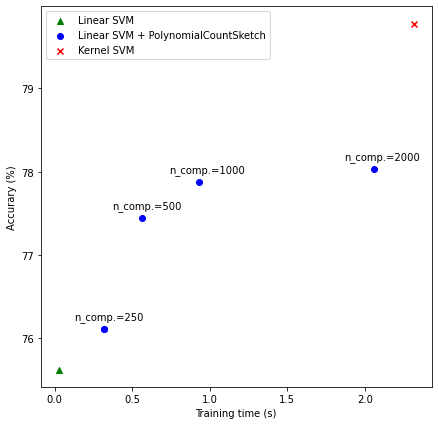

In [9]:
N_COMPONENTS = [250, 500, 1000, 2000]

fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter([results["LSVM"]["time"], ], [results["LSVM"]["score"], ],
           label="Linear SVM", c="green", marker="^")

ax.scatter([results["LSVM + PS(250)"]["time"], ],
           [results["LSVM + PS(250)"]["score"], ],
           label="Linear SVM + PolynomialCountSketch", c="blue")
for n_components in N_COMPONENTS:
    ax.scatter([results[f"LSVM + PS({n_components})"]["time"], ],
               [results[f"LSVM + PS({n_components})"]["score"], ],
               c="blue")
    ax.annotate(f"n_comp.={n_components}",
                (results[f"LSVM + PS({n_components})"]["time"],
                 results[f"LSVM + PS({n_components})"]["score"]),
                xytext=(-30, 10), textcoords="offset pixels")

ax.scatter([results["KSVM"]["time"], ], [results["KSVM"]["score"], ],
           label="Kernel SVM", c="red", marker="x")

ax.set_xlabel("Training time (s)")
ax.set_ylabel("Accurary (%)")
ax.legend()
plt.show()

## References

[1] Pham, Ninh and Rasmus Pagh. "Fast and scalable polynomial kernels via
explicit feature maps." KDD '13 (2013).
https://doi.org/10.1145/2487575.2487591

[2] LIBSVM binary datasets repository
https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary.html



2021-06-10 16:36:41,186	INFO services.py:1267 -- View the Ray dashboard at http://127.0.0.1:8266


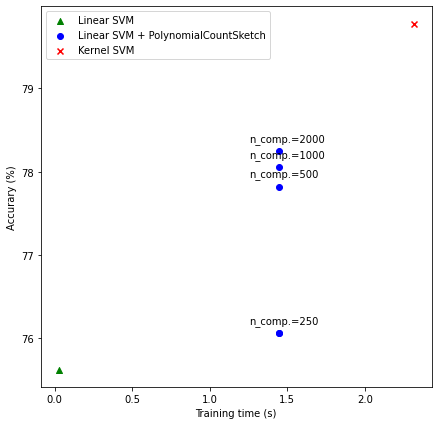

In [10]:
import ray
import codeflare.pipelines.Datamodel as dm
import codeflare.pipelines.Runtime as rt
from codeflare.pipelines.Datamodel import Xy
from codeflare.pipelines.Datamodel import XYRef
from codeflare.pipelines.Runtime import ExecutionType

ray.shutdown()
ray.init()

n_runs = 3
score_250 = 0
score_500 = 0
score_1000 = 0
score_2000 = 0
run_time = 0

for _ in range(n_runs):
    
    start = time.time()
    
    pipeline = dm.Pipeline()
    node_pcs250 = dm.EstimatorNode("kernel_approximator_250", PolynomialCountSketch(n_components=250,
                                        degree=4))
    node_pcs500 = dm.EstimatorNode("kernel_approximator_500", PolynomialCountSketch(n_components=500,
                                        degree=4))
    node_pcs1000 = dm.EstimatorNode("kernel_approximator_1000", PolynomialCountSketch(n_components=1000,
                                        degree=4))
    node_pcs2000 = dm.EstimatorNode("kernel_approximator_2000", PolynomialCountSketch(n_components=2000,
                                        degree=4))
    node_clf250 = dm.EstimatorNode("linear_classifier_250", LinearSVC())
    node_clf500 = dm.EstimatorNode("linear_classifier_500", LinearSVC())
    node_clf1000 = dm.EstimatorNode("linear_classifier_1000", LinearSVC())
    node_clf2000 = dm.EstimatorNode("linear_classifier_2000", LinearSVC())
    
    pipeline.add_edge(node_pcs250, node_clf250)
    pipeline.add_edge(node_pcs500, node_clf500)
    pipeline.add_edge(node_pcs1000, node_clf1000)
    pipeline.add_edge(node_pcs2000, node_clf2000)
    
    # create training input
    train_input = dm.PipelineInput()
    xy_train = dm.Xy(X_train, y_train)
    train_input.add_xy_arg(node_pcs250, xy_train)
    train_input.add_xy_arg(node_pcs500, xy_train)
    train_input.add_xy_arg(node_pcs1000, xy_train)
    train_input.add_xy_arg(node_pcs2000, xy_train)
    
    # codeflare pipeline is able to execute model FIT once with four n_components 
    pipeline_fitted = rt.execute_pipeline(pipeline, ExecutionType.FIT, train_input)
    
    xy_test = dm.Xy(X_test, y_test)
    
    test_input = dm.PipelineInput()
    test_input.add_xy_arg(node_pcs250, xy_test)
    pipeline_250 = rt.select_pipeline(pipeline_fitted, pipeline_fitted.get_xyrefs(node_clf250)[0])
    score_250 += 100 * ray.get(rt.execute_pipeline(pipeline_250, ExecutionType.SCORE, test_input)
                    .get_xyrefs(node_clf250)[0].get_Xref())
    
    test_input = dm.PipelineInput()
    test_input.add_xy_arg(node_pcs500, xy_test)
    pipeline_500 = rt.select_pipeline(pipeline_fitted, pipeline_fitted.get_xyrefs(node_clf500)[0])
    score_500 += 100 * ray.get(rt.execute_pipeline(pipeline_500, ExecutionType.SCORE, test_input)
                    .get_xyrefs(node_clf500)[0].get_Xref())
    
    test_input = dm.PipelineInput()
    test_input.add_xy_arg(node_pcs1000, xy_test)
    pipeline_1000 = rt.select_pipeline(pipeline_fitted, pipeline_fitted.get_xyrefs(node_clf1000)[0])
    score_1000 += 100 * ray.get(rt.execute_pipeline(pipeline_1000, ExecutionType.SCORE, test_input)
                    .get_xyrefs(node_clf1000)[0].get_Xref())
    
    test_input = dm.PipelineInput()
    test_input.add_xy_arg(node_pcs2000, xy_test)
    pipeline_2000 = rt.select_pipeline(pipeline_fitted, pipeline_fitted.get_xyrefs(node_clf2000)[0])
    score_2000 += 100 * ray.get(rt.execute_pipeline(pipeline_2000, ExecutionType.SCORE, test_input)
                    .get_xyrefs(node_clf2000)[0].get_Xref())

    run_time += ((time.time() - start)/4)

# all runs have the the same run time since they are FITTED together
results[f"LSVM + PS(250)"] = {
        "time": run_time/n_runs, "score": score_250/n_runs
}
results[f"LSVM + PS(500)"] = {
        "time": run_time/n_runs, "score": score_500/n_runs
}
results[f"LSVM + PS(1000)"] = {
        "time": run_time/n_runs, "score": score_1000/n_runs
}
results[f"LSVM + PS(2000)"] = {
        "time": run_time/n_runs, "score": score_2000/n_runs
}


N_COMPONENTS = [250, 500, 1000, 2000]

fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter([results["LSVM"]["time"], ], [results["LSVM"]["score"], ],
           label="Linear SVM", c="green", marker="^")

ax.scatter([results["LSVM + PS(250)"]["time"], ],
           [results["LSVM + PS(250)"]["score"], ],
           label="Linear SVM + PolynomialCountSketch", c="blue")
for n_components in N_COMPONENTS:
    ax.scatter([results[f"LSVM + PS({n_components})"]["time"], ],
               [results[f"LSVM + PS({n_components})"]["score"], ],
               c="blue")
    ax.annotate(f"n_comp.={n_components}",
                (results[f"LSVM + PS({n_components})"]["time"],
                 results[f"LSVM + PS({n_components})"]["score"]),
                xytext=(-30, 10), textcoords="offset pixels")

ax.scatter([results["KSVM"]["time"], ], [results["KSVM"]["score"], ],
           label="Kernel SVM", c="red", marker="x")

ax.set_xlabel("Training time (s)")
ax.set_ylabel("Accurary (%)")
ax.legend()
plt.show()

ray.shutdown()